### GAN
 - GAN은 강화학습은 아니지만, 또 독특한 형태의 학습이라서 잠깐 다루고 넘어가야 할 것 같다.
 - GAN은 2014년에 등장하면서 생성형 모델의 패러다임 자체를 바꾼 모델이다.
   - 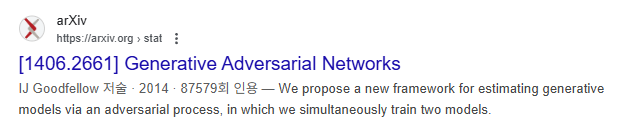
 - 가짜 이미지를 생성하는 Generator 와
 - 지금 들어온 이미지가 Generator 가 생성한 이미지인지, 실제 이미지인지 구분하는 Discriminator 두 모델을
 - `경쟁적`으로 학습시킨다.
 - VAE 와 비교해서, VAE는 확률적 구조 + 복원을 목표
 - GAN은 구별기를 속이는 것이 목표 로 목표가 다르다.

### GAN의 구조
1) Generator (G)
 - 랜덤한 입력(노이즈) → "그럴듯한 가짜 이미지" 생성
 - 목표: Discriminator를 속이는 것

2) Discriminator (D)

 - 입력 이미지가 진짜인지, 가짜인지 판단
 - 목표: Generator가 만든 가짜를 정확히 잡아내는 것
 - → G와 D가 서로 경쟁하는 구조

### 목표
 - G는 더 정교한 가짜 이미지를 만들기
 - D는 더 정교한 감별력을 기르기

두 모델이 서로 성능을 밀어붙이며 발전하는 미니맥스(minimax) 게임
(미니맥스게임이란, 상대의 최댓값을 최소화 하는 게임)


### GAN 의 Loss
 - D의 목적
   - 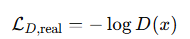
    - 진짜 이미지는 1 (진실) 로 분류 하고 싶다
   - 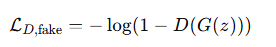
    - 가짜 이미지는 0 (거짓) 으로 분류 하고 싶다.
   - 진실 1, 거짓 0 으로 바꾸면 loss 부호도 바꿔 줘야 함.
   - 그래서 D는
     - 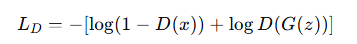
     - 이 둘을 더한 것을 loss 로 사용해야 한다.
       - 진짜인건 진짜로 분류하는데 성공했고, 가짜인건 가짜인것처럼 분류 성공해야 Loss 가 낮아짐.
 - G의 목적
   - 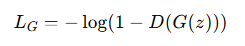
     - 그냥 D만 속이면 성공이라, D가 진짜 이미지를 어떻게 판별하는지는 신경 쓰지 않는다.
 - 위 두 식을 합쳐 적으면...!
   - 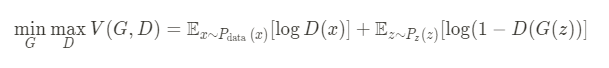

 - 보통 학습 할때는 D의 현재 상태를 기준으로 G를 업데이트 해야 하기 때문에,
   - G는 최신의 D에 대해서 학습 하는게 좋다 (위조지폐범은 만들고 그 뒤에 경찰이 배우는데, 얘는 학습된 경찰한테 이후 나의 지폐를 테스트 할 수 있다.)
   - 그래서 보통 D 먼저 업데이트 하고, 그 뒤에 G를 업데이트 한다.

### GAN의 비유
 - 흔히들 경찰과 위조지폐범 예를 많이 드는데,
 - 위조 지폐범이 위조지폐를 더 잘 만들면 만들수록, 경찰 역시 위조지폐를 감별하는 능력이 길러져야 한다.
 - 그리고 이렇게 더 잘 구별하는 경찰을 속이려면, 위조 지폐범도 위조지폐를 더 잘 만들어야한다.
 - 이것을 코드로 구현한 것이다.

### GAN의 장점
 - VAE 에 비해서, 선명한 이미지가 나온다
 - VAE는 픽셀을 손실된 상태에서 재구성 하고 있어서, 평균적인 복원이라 흐릿한 이미지가 나온다
 - GAN은 분포 자체를 속이는것이라, 실제 데이터의 분포도를 따라가려고 노력한다.
 - GAN은 통계적 모델링이 필요 없다. p(x)를 직접 정의할 필요는 없음

### GAN의 단점
 - 학습이 매우 매우 불안정하다.
 - Generator 와 Discriminator 의 균형을 잡기 매우 어렵다.
  - 경쟁에서 한쪽이 우위를 차지해버리면, 학습이 안 된다.
  - G나 D 가 한쪽으로 치우치는 순간 게임이 안 됨. (약한 나머지 한 쪽이 찍기를 하고 있을 뿐임)
 - GAN이 Discriminator가 속을만한 몇 가지 특정한 패턴만 생성하는 문제가 종종 존재 함.

In [3]:
# Vanlia GAN

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

latent_dim = 100
batch_size = 256
num_epochs = 50
lr = 2e-4
sample_dir = "gan_samples"

os.makedirs(sample_dir, exist_ok=True)

# 2. 데이터 로더 (MNIST)
# - [-1, 1] 범위로 정규화 (Generator 출력과 맞추기 위해)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))  # [0,1] -> [-1,1]
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True,
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


class Generator(nn.Module):
    """
    z (노이즈, [batch, latent_dim]) -> [batch, 1, 28, 28]
    """
    def __init__(self, latent_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(1024, 28 * 28),
            nn.Tanh(),  # 출력 [-1,1]
        )

    def forward(self, z):
        x = self.net(z)              # [B, 784]
        x = x.view(-1, 1, 28, 28)    # [B, 1, 28, 28]
        return x


class Discriminator(nn.Module):
    """
    x ([batch, 1, 28, 28]) -> 스칼라 (logit, 진짜/가짜)
    """
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),            # 1x28x28 -> 784
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 1),       # logit
        )

    def forward(self, x):
        return self.net(x).view(-1) 

Device: cuda


Generator params: 1486352
Discriminator params: 533505
[Epoch 1/50] Loss_D: 1.2784, Loss_G: 0.7891


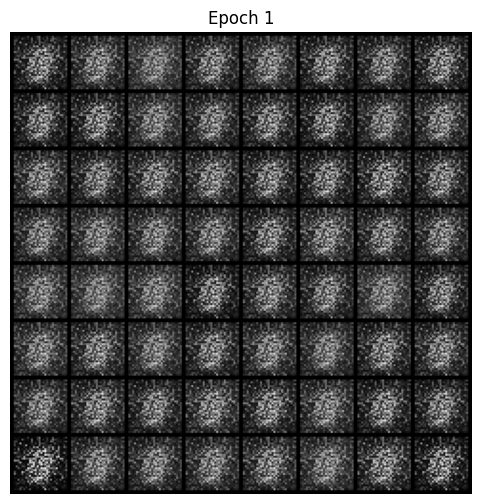

[Epoch 2/50] Loss_D: 1.1477, Loss_G: 1.0004
[Epoch 3/50] Loss_D: 1.0981, Loss_G: 1.3364
[Epoch 4/50] Loss_D: 1.1234, Loss_G: 1.4101
[Epoch 5/50] Loss_D: 1.0313, Loss_G: 1.5157


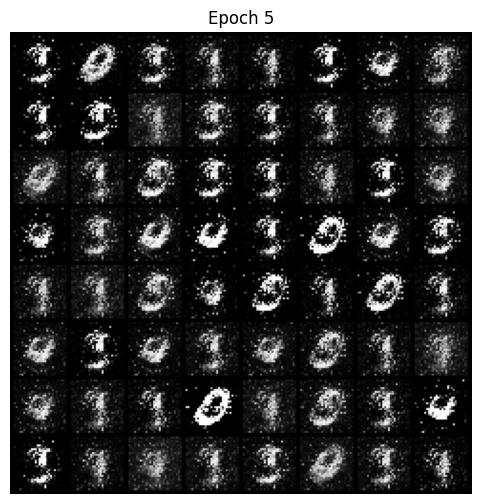

[Epoch 6/50] Loss_D: 1.0608, Loss_G: 1.6333
[Epoch 7/50] Loss_D: 0.9721, Loss_G: 1.6333
[Epoch 8/50] Loss_D: 1.0109, Loss_G: 1.6394
[Epoch 9/50] Loss_D: 0.9228, Loss_G: 1.7886
[Epoch 10/50] Loss_D: 0.9674, Loss_G: 1.7763


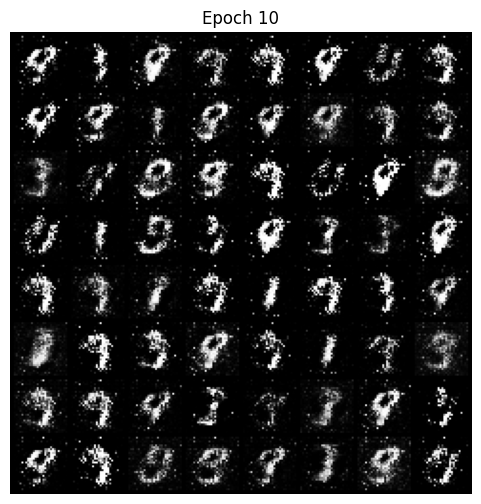

[Epoch 11/50] Loss_D: 0.9438, Loss_G: 1.6607
[Epoch 12/50] Loss_D: 0.9665, Loss_G: 1.6419
[Epoch 13/50] Loss_D: 0.9300, Loss_G: 1.6652
[Epoch 14/50] Loss_D: 0.9490, Loss_G: 1.6561
[Epoch 15/50] Loss_D: 0.8955, Loss_G: 1.9146


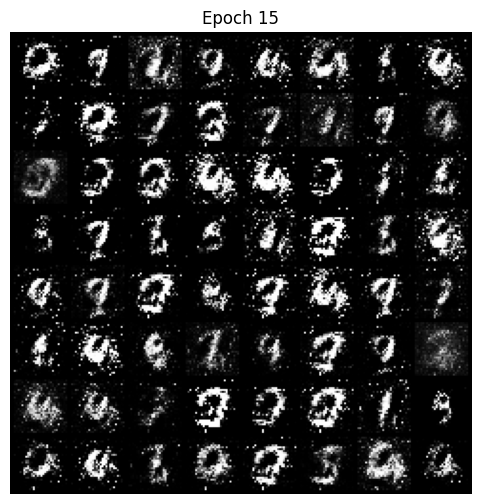

[Epoch 16/50] Loss_D: 0.9126, Loss_G: 1.6718
[Epoch 17/50] Loss_D: 0.8869, Loss_G: 1.7077
[Epoch 18/50] Loss_D: 0.9209, Loss_G: 1.5961
[Epoch 19/50] Loss_D: 0.9917, Loss_G: 1.4638
[Epoch 20/50] Loss_D: 1.0000, Loss_G: 1.4413


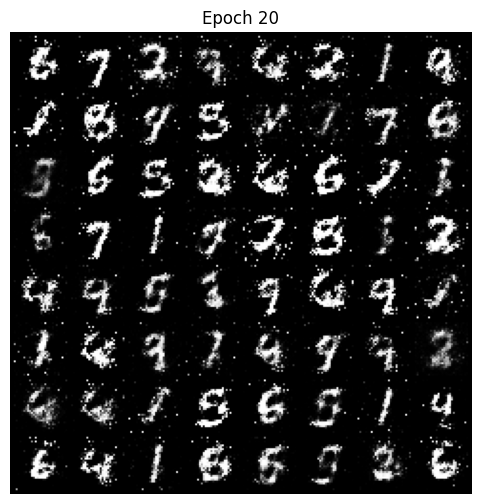

[Epoch 21/50] Loss_D: 1.0621, Loss_G: 1.3036
[Epoch 22/50] Loss_D: 1.0896, Loss_G: 1.2382
[Epoch 23/50] Loss_D: 1.1166, Loss_G: 1.1844
[Epoch 24/50] Loss_D: 1.1394, Loss_G: 1.1291
[Epoch 25/50] Loss_D: 1.1367, Loss_G: 1.1500


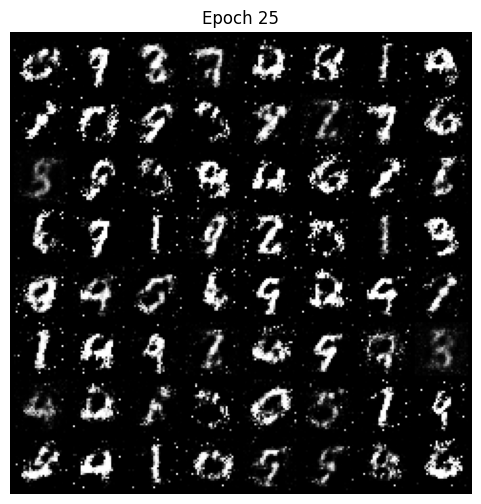

[Epoch 26/50] Loss_D: 1.1684, Loss_G: 1.1031
[Epoch 27/50] Loss_D: 1.1954, Loss_G: 1.0468
[Epoch 28/50] Loss_D: 1.1892, Loss_G: 1.0724
[Epoch 29/50] Loss_D: 1.2036, Loss_G: 1.0247
[Epoch 30/50] Loss_D: 1.2059, Loss_G: 1.0129


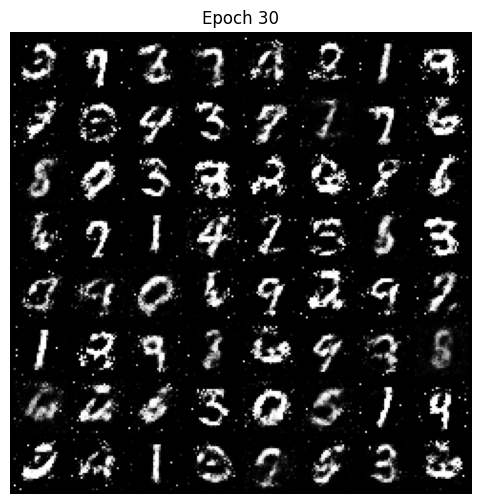

[Epoch 31/50] Loss_D: 1.2227, Loss_G: 1.0132
[Epoch 32/50] Loss_D: 1.2168, Loss_G: 1.0112
[Epoch 33/50] Loss_D: 1.2145, Loss_G: 1.0078
[Epoch 34/50] Loss_D: 1.2139, Loss_G: 1.0230
[Epoch 35/50] Loss_D: 1.2121, Loss_G: 1.0051


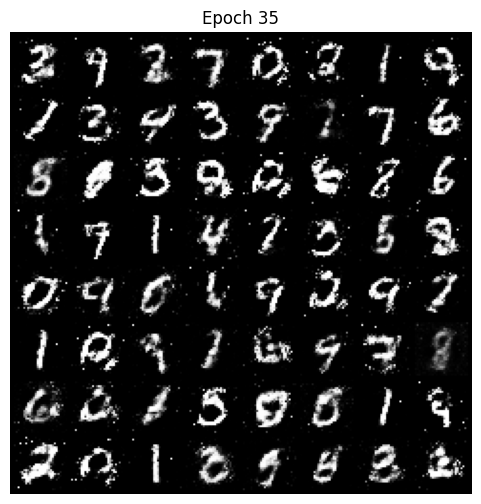

[Epoch 36/50] Loss_D: 1.2214, Loss_G: 0.9989
[Epoch 37/50] Loss_D: 1.2248, Loss_G: 0.9871
[Epoch 38/50] Loss_D: 1.2253, Loss_G: 0.9817
[Epoch 39/50] Loss_D: 1.2313, Loss_G: 0.9760
[Epoch 40/50] Loss_D: 1.2273, Loss_G: 0.9827


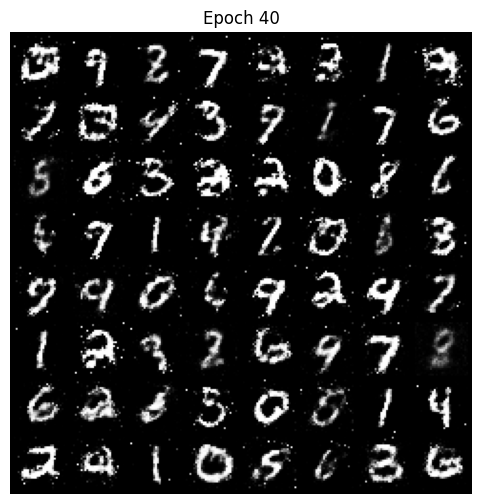

[Epoch 41/50] Loss_D: 1.2455, Loss_G: 0.9739
[Epoch 42/50] Loss_D: 1.2408, Loss_G: 0.9540
[Epoch 43/50] Loss_D: 1.2525, Loss_G: 0.9500
[Epoch 44/50] Loss_D: 1.2507, Loss_G: 0.9372
[Epoch 45/50] Loss_D: 1.2556, Loss_G: 0.9410


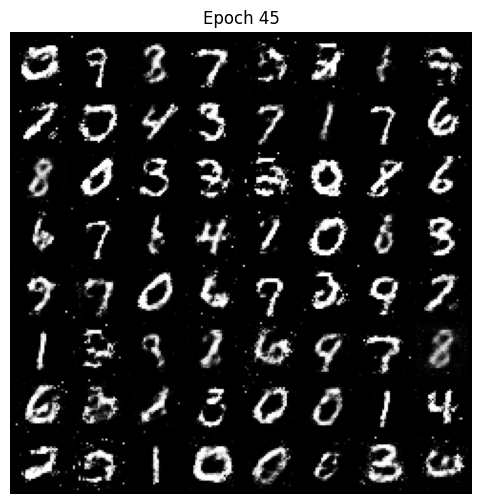

[Epoch 46/50] Loss_D: 1.2498, Loss_G: 0.9383
[Epoch 47/50] Loss_D: 1.2562, Loss_G: 0.9419
[Epoch 48/50] Loss_D: 1.2608, Loss_G: 0.9227
[Epoch 49/50] Loss_D: 1.2493, Loss_G: 0.9508
[Epoch 50/50] Loss_D: 1.2552, Loss_G: 0.9453


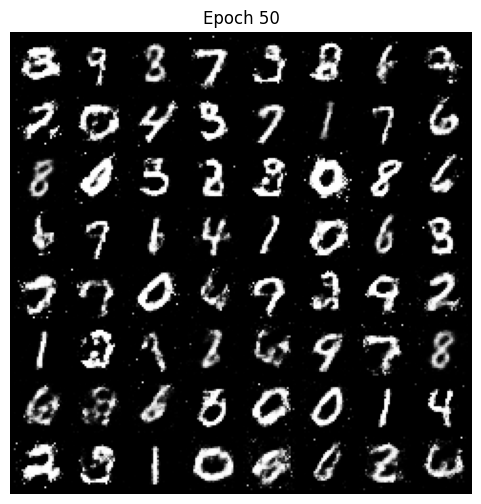

GAN models saved: gan_generator.pth, gan_discriminator.pth


In [ ]:

G = Generator(latent_dim).to(device)
D = Discriminator().to(device)

print("Generator params:", sum(p.numel() for p in G.parameters()))
print("Discriminator params:", sum(p.numel() for p in D.parameters()))

# 내부적으로 BCEWithLogitsLoss(x,y)=max(x,0)−x⋅y+log(1+exp(−∣x∣)) 이 식을 사용한다.
# log(0) 과 같은 문제 방지.
criterion = nn.BCEWithLogitsLoss()
opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# 고정 노이즈 (학습 과정 시각화용)
fixed_z = torch.randn(64, latent_dim, device=device)

def save_samples(epoch, z=None):
    G.eval()
    with torch.no_grad():
        if z is None:
            z = torch.randn(64, latent_dim, device=device)
        fake = G(z).cpu()
    G.train()

    fake = (fake + 1) / 2.0
    grid = utils.make_grid(fake, nrow=8)
    npimg = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(6,6))
    plt.imshow(npimg, cmap="gray")
    plt.axis("off")
    plt.title(f"Epoch {epoch}")
    plt.show()

    utils.save_image(fake, os.path.join(sample_dir, f"epoch_{epoch:03d}.png"), nrow=8)


for epoch in range(1, num_epochs + 1):
    G.train()
    D.train()
    running_loss_G = 0.0
    running_loss_D = 0.0

    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)
        batch_size_curr = real_imgs.size(0)

        # Discriminator 학습
        # 진짜 라벨 = 1, 가짜 라벨 = 0
        real_labels = torch.ones(batch_size_curr, device=device)
        fake_labels = torch.zeros(batch_size_curr, device=device)

        # 진짜에 대한 loss
        logits_real = D(real_imgs)
        loss_D_real = criterion(logits_real, real_labels)

        # 가짜에 대한 loss
        z = torch.randn(batch_size_curr, latent_dim, device=device)
        fake_imgs = G(z).detach()  # G 업데이트 방지
        logits_fake = D(fake_imgs)
        loss_D_fake = criterion(logits_fake, fake_labels)

        loss_D = loss_D_real + loss_D_fake

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # Generator 학습
        # Generator는 "가짜를 진짜로 속이고 싶음" -> D(fake)를 1로 만들고 싶다
        z = torch.randn(batch_size_curr, latent_dim, device=device)
        fake_imgs = G(z)
        logits_fake_for_G = D(fake_imgs)
        # 여기서는 label=1 (진짜처럼 보이게!)
        loss_G = criterion(logits_fake_for_G, real_labels)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        running_loss_D += loss_D.item()
        running_loss_G += loss_G.item()

    avg_loss_D = running_loss_D / len(train_loader)
    avg_loss_G = running_loss_G / len(train_loader)

    print(f"[Epoch {epoch}/{num_epochs}] "
          f"Loss_D: {avg_loss_D:.4f}, Loss_G: {avg_loss_G:.4f}")

    # 몇 epoch마다 샘플 시각화
    if epoch == 1 or epoch % 5 == 0 or epoch == num_epochs:
        save_samples(epoch, fixed_z)

# 학습이 끝난 뒤 모델 저장 (나중에 불러와서 생성 데모 가능)
torch.save(G.state_dict(), "gan_generator.pth")
torch.save(D.state_dict(), "gan_discriminator.pth")
print("GAN models saved: gan_generator.pth, gan_discriminator.pth")

Device: cuda
Loaded generator from gan_generator.pth


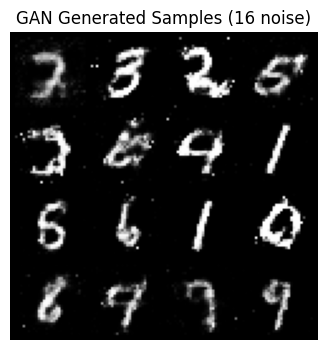

In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

latent_dim = 100 

G = Generator(latent_dim).to(device)
state = torch.load("gan_generator.pth", map_location=device)
G.load_state_dict(state)
G.eval()
print("Loaded generator from gan_generator.pth")

with torch.no_grad():
    z = torch.randn(16, latent_dim, device=device)  # 16개 샘플
    fake = G(z).cpu()  # [16, 1, 28, 28]

# [-1,1] → [0,1] 로 되돌리기
fake = (fake + 1) / 2.0

grid = utils.make_grid(fake, nrow=4, padding=2)
npimg = grid.permute(1, 2, 0).numpy()

plt.figure(figsize=(4,4))
plt.imshow(npimg, cmap="gray")
plt.axis("off")
plt.title("GAN Generated Samples (16 noise)")
plt.show()
